In [1]:
!pip install ta

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

{}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d borismarjanovic/price-volume-data-for-all-us-stocks-etfs

Dataset URL: https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs
License(s): CC0-1.0
price-volume-data-for-all-us-stocks-etfs.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
import zipfile
zip_ref = zipfile.ZipFile('price-volume-data-for-all-us-stocks-etfs.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
import pandas as pd
tickers = pd.read_csv('SP Tickers.csv')
tickers = set(tickers['symbol'].tolist())

In [7]:
from data_preparation import *
from plotting import *
from strategies import *
from backtest import *

In [8]:
stock_df = load_df(tickers)

/content/plotting.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Year', y='Count', data=rows_per_year, palette='viridis')


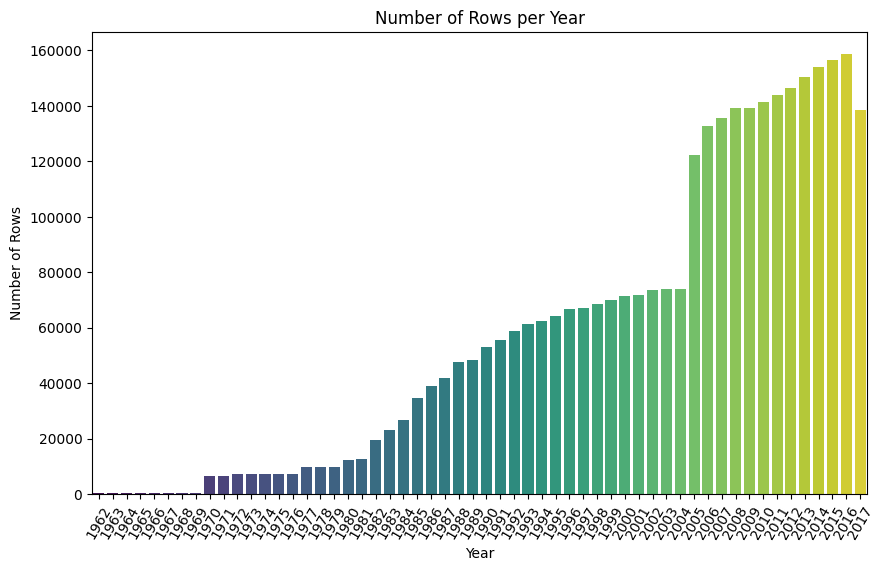

In [ ]:
plot_entries_per_year(stock_df)

In [9]:
TRAINING_START_DATE = pd.to_datetime("2010-01-01")
TRAINING_END_DATE = pd.to_datetime("2012-12-31")

BACKTEST_START_DATE = pd.to_datetime("2013-01-01")
BACKTEST_END_DATE = pd.to_datetime("2017-12-31")

In [ ]:
X_train, X_test, y_train, y_test = get_train_test(stock_df, tickers, TRAINING_START_DATE, TRAINING_END_DATE, task='regression')

In [10]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
X_train_tensor = torch.FloatTensor(X_train.values).to(device)
y_train_tensor = torch.FloatTensor(y_train.values.reshape(-1, 1)).to(device)
X_val_tensor = torch.FloatTensor(X_test.values).to(device)
y_val_tensor = torch.FloatTensor(y_test.values.reshape(-1, 1)).to(device)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size=1, normalization=None):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_layers[0]))

        # Hidden layers
        for i in range(len(hidden_layers) - 1):
            self.layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            if normalization == 'BN':
                self.layers.append(nn.BatchNorm1d(hidden_layers[i+1]))
            elif normalization == 'LN':
                self.layers.append(nn.LayerNorm(hidden_layers[i+1]))
            self.layers.append(nn.ReLU())

        # Output layer
        self.layers.append(nn.Linear(hidden_layers[-1], output_size))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

def train_mlp(X_train, y_train, X_val, y_val, train_loader, hidden_layers=[64, 32], normalization=None, lr=0.001, epochs=100, early_stopping_patience=2, log=True):
    # Initialize the model
    input_size = X_train.shape[1]
    model = MLP(input_size, hidden_layers, normalization=normalization).to(device)

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Early stopping variables
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)

        if log:
          print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss.item():.4f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= early_stopping_patience:
                if log:
                  print(f"Early stopping triggered after {epoch+1} epochs")
                break

    # Load the best model
    model.load_state_dict(torch.load('best_model.pth'))
    return model

def predict(model, X):
    device = next(model.parameters()).device
    model.eval()
    X_tensor = torch.FloatTensor(X.values).to(device)
    with torch.no_grad():
        outputs = model(X_tensor)
    return outputs

In [ ]:
from sklearn.metrics import mean_squared_error
import random
best_model, best_val_loss = None, float('inf')

num_hidden_layers_range = [2, 3, 4, 5]
hidden_layer_sizes = [128, 256, 512, 1024]
batch_sizes = [128, 256]
learning_rates = [0.0005, 0.0001]

for _ in range(20):
    # Randomly select number of hidden layers
    num_hidden_layers = random.choice(num_hidden_layers_range)
    hidden_layers = [random.choice(hidden_layer_sizes)] * num_hidden_layers

    batch_size = random.choice(batch_sizes)
    learning_rate = random.choice(learning_rates)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = train_mlp(X_train, y_train, X_test, y_test, train_loader, hidden_layers, lr=learning_rate, normalization='LN', log=False)
    y_pred = predict(model, X_test)

    if mean_squared_error(y_test, y_pred.cpu()) < best_val_loss:
        best_model = model
        best_val_loss = mean_squared_error(y_test, y_pred.cpu())
        print(f"Hidden Layers: {hidden_layers}, Batch Size: {batch_size}, Learning Rate: {learning_rate}")
        print(f"Best Validation Loss: {best_val_loss}")

Hidden Layers: [512, 512, 512, 512, 512], Batch Size: 256, Learning Rate: 0.0005
Best Validation Loss: 501.7263018524265
Hidden Layers: [256, 256], Batch Size: 256, Learning Rate: 0.0005
Best Validation Loss: 437.38222298070275
Hidden Layers: [128, 128, 128], Batch Size: 128, Learning Rate: 0.0001
Best Validation Loss: 411.3344562462694


In [ ]:
from sklearn.metrics import mean_squared_error
import random

best_model, best_val_loss = None, float('inf')

for n_hidden_layers in [2, 3, 4]:
  for batch_size in [64, 128, 256]:
    for learning_rate in [0.0001, 0.0005]:
      for hidden_size in [64, 128, 256]:
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        hidden_layers = [hidden_size] * n_hidden_layers

        print(f"Hidden Layers: {hidden_layers}, Batch Size: {batch_size}, Learning Rate: {learning_rate}")

        model = train_mlp(X_train, y_train, X_test, y_test, train_loader, hidden_layers, lr=learning_rate, normalization='LN', log=False)
        y_pred = predict(model, X_test)

        if mean_squared_error(y_test, y_pred.cpu()) < best_val_loss:
            best_model = model
            best_val_loss = mean_squared_error(y_test, y_pred.cpu())
            print(f"New Best Validation Loss: {best_val_loss}")

Hidden Layers: [64, 64], Batch Size: 64, Learning Rate: 0.0001
New Best Validation Loss: 506.20600512976716
Hidden Layers: [128, 128], Batch Size: 64, Learning Rate: 0.0001
Hidden Layers: [256, 256], Batch Size: 64, Learning Rate: 0.0001
Hidden Layers: [64, 64], Batch Size: 64, Learning Rate: 0.0005
Hidden Layers: [128, 128], Batch Size: 64, Learning Rate: 0.0005
Hidden Layers: [256, 256], Batch Size: 64, Learning Rate: 0.0005
Hidden Layers: [64, 64], Batch Size: 128, Learning Rate: 0.0001
Hidden Layers: [128, 128], Batch Size: 128, Learning Rate: 0.0001
Hidden Layers: [256, 256], Batch Size: 128, Learning Rate: 0.0001
Hidden Layers: [64, 64], Batch Size: 128, Learning Rate: 0.0005
Hidden Layers: [128, 128], Batch Size: 128, Learning Rate: 0.0005
Hidden Layers: [256, 256], Batch Size: 128, Learning Rate: 0.0005
Hidden Layers: [64, 64], Batch Size: 256, Learning Rate: 0.0001
Hidden Layers: [128, 128], Batch Size: 256, Learning Rate: 0.0001
Hidden Layers: [256, 256], Batch Size: 256, Lea

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
best_model = train_mlp(X_train, y_train, X_test, y_test, train_loader, [256, 256, 256, 256], lr=0.0001, normalization='LN', early_stopping_patience=5)

Epoch 1/100, Validation Loss: 1623.4255
Epoch 2/100, Validation Loss: 1412.0006
Epoch 3/100, Validation Loss: 1307.1887
Epoch 4/100, Validation Loss: 1155.5901
Epoch 5/100, Validation Loss: 1040.4102
Epoch 6/100, Validation Loss: 988.1427
Epoch 7/100, Validation Loss: 860.6740
Epoch 8/100, Validation Loss: 795.4144
Epoch 9/100, Validation Loss: 750.2885
Epoch 10/100, Validation Loss: 664.1498
Epoch 11/100, Validation Loss: 638.6600
Epoch 12/100, Validation Loss: 662.6902
Epoch 13/100, Validation Loss: 584.9508
Epoch 14/100, Validation Loss: 580.7018
Epoch 15/100, Validation Loss: 560.8780
Epoch 16/100, Validation Loss: 552.3757
Epoch 17/100, Validation Loss: 542.1787
Epoch 18/100, Validation Loss: 535.9440
Epoch 19/100, Validation Loss: 582.6283
Epoch 20/100, Validation Loss: 500.6287
Epoch 21/100, Validation Loss: 593.6927
Epoch 22/100, Validation Loss: 487.7515
Epoch 23/100, Validation Loss: 497.6518
Epoch 24/100, Validation Loss: 464.1179
Epoch 25/100, Validation Loss: 455.6354
Epoc

In [19]:
mlp = MLP(90, [256, 256, 256, 256], normalization='LN')
mlp.load_state_dict(torch.load('best_mlp.pth'))

<All keys matched successfully>

In [11]:
backtest_df = get_features_df(stock_df, tickers, BACKTEST_START_DATE, BACKTEST_END_DATE, mode='backtest', task='regression')

In [13]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out.squeeze()

In [14]:
from data_preparation import get_rnn_dataset
train_dataset, test_dataset, feature_columns = get_rnn_dataset(backtest_df, 5)

In [22]:
import torch.optim as optim
from sklearn.metrics import mean_squared_error

def train_rnn(model, train_loader, val_loader, lr=0.001, epochs=100, early_stopping_patience=10, log=True, rnn_type='lstm'):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        all_val_outputs = []
        all_val_targets = []
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                all_val_outputs.append(outputs.cpu().numpy())
                all_val_targets.append(batch_y.cpu().numpy())

        all_val_outputs = np.concatenate(all_val_outputs)
        all_val_targets = np.concatenate(all_val_targets)

        val_loss = mean_squared_error(all_val_targets, all_val_outputs)

        if log:
            print(f"Epoch {epoch+1}/{epochs}, Validation MSE: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), f'best_{rnn_type}.pth')
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= early_stopping_patience:
                if log:
                    print(f"Early stopping triggered after {epoch+1} epochs")
                break

    model.load_state_dict(torch.load(f'best_{rnn_type}.pth'))
    return model

In [24]:
from torch.utils.data import DataLoader

input_size = len(feature_columns)
hidden_size = 64
num_layers = 2

lstm = LSTM(input_size, hidden_size, num_layers)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

lstm = LSTM(input_size, hidden_size, num_layers).to(device)
train_rnn(lstm, train_loader, test_loader, lr=0.0005, early_stopping_patience=5, rnn_type='lstm')

Epoch 1/100, Validation MSE: 9192.3945
Epoch 2/100, Validation MSE: 8853.9541
Epoch 3/100, Validation MSE: 8405.2441


KeyboardInterrupt: 